# Testing InceptionV3 network (variation 16) Fine-tuning w/ Dropout

Based on variant 15 but with __dropout at 0.2__ not 0.5:

`model = Sequential()
model.add(conv_base)
model.add(Dropout(0.2, seed=21))
model.add(Dense(**pred_layer_config))`


`optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)`

In [1]:
import os
import time
import pickle

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import metrics

#TODO implement this function
from cars_utils import time_save_model, plot_metrics

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Image, directory, and batch setup

In [2]:
# Image dimensions:
IMG_WIDTH, IMG_HEIGHT = 299, 299

WORKING_DIR = os.getcwd()
BASE = os.path.join(WORKING_DIR, 'data', 'cars_dataset', 'keras')

SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'InceptionV3')

### Settings for full training
TRAIN_DATA_DIR = os.path.join(BASE, 'train')
VALIDATION_DATA_DIR = os.path.join(BASE, 'validation')
NB_CLASSES = 196
NB_TRAIN_SAMPLES = 11329
NB_VALIDATION_SAMPLES = 2428
BATCH_SIZE = 32

### Settings for fast checking
# SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'fast_test')
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast', 'validation')
# NB_CLASSES = 196
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

### Settings for faster checking
# SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'fast_v2_test')
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast_v2', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast_v2', 'validation')
# NB_CLASSES = 6
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

## Image augmentation generators

In [3]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=7)

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=13)

Found 11329 images belonging to 196 classes.
Found 2428 images belonging to 196 classes.


## Model definition

In [5]:
from keras.applications import InceptionV3

conv_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=INPUT_SHAPE
)

In [ ]:
# from keras.utils import plot_model
# plot_model(conv_base, to_file='conv_base.png')

In [22]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
pred_layer_config = {
    'activation': 'softmax',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
                           'config': {
                               'distribution': 'uniform',
                               'mode': 'fan_avg',
                               'scale': 1.0,
                               'seed': 8}
                          },
    'kernel_regularizer': None,
    'name': 'predictions',
    'trainable': True,
    'units': NB_CLASSES,
    'use_bias': True}

model = Sequential()
model.add(conv_base)
model.add(Dropout(0.2, seed=21))
model.add(Dense(**pred_layer_config))

In [8]:
conv_base.trainable = True
# for layer in conv_base.layers:
#     layer.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 190
This is the number of trainable weights before freezing the conv base: 2


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 196)               401604    
Total params: 22,204,388
Trainable params: 401,604
Non-trainable params: 21,802,784
_________________________________________________________________


## Compile model

In [9]:
# custom metrics to look at
def top_3_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

In [10]:
from keras import optimizers

optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_3_acc, top_5_acc])

## Train model!

In [11]:
EPOCHS = 10
start_time = time.time()
summary = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE)
end_time = time.time()

Epoch 1/10
354/354 [==============================] - 314s 888ms/step - loss: 5.0960 - categorical_accuracy: 0.0364 - top_3_acc: 0.0868 - top_5_acc: 0.1263 - val_loss: 4.3408 - val_categorical_accuracy: 0.0825 - val_top_3_acc: 0.1867 - val_top_5_acc: 0.2612
Epoch 2/10
354/354 [==============================] - 291s 823ms/step - loss: 4.2529 - categorical_accuracy: 0.1155 - top_3_acc: 0.2280 - top_5_acc: 0.3009 - val_loss: 3.8203 - val_categorical_accuracy: 0.1325 - val_top_3_acc: 0.2762 - val_top_5_acc: 0.3775
Epoch 3/10
354/354 [==============================] - 291s 821ms/step - loss: 3.8638 - categorical_accuracy: 0.1706 - top_3_acc: 0.3138 - top_5_acc: 0.3909 - val_loss: 3.5917 - val_categorical_accuracy: 0.1783 - val_top_3_acc: 0.3442 - val_top_5_acc: 0.4363
Epoch 4/10
354/354 [==============================] - 292s 826ms/step - loss: 3.6443 - categorical_accuracy: 0.2039 - top_3_acc: 0.3586 - top_5_acc: 0.4437 - val_loss: 3.4078 - val_categorical_accuracy: 0.2121 - val_top_3_acc:

In [13]:
time_save_model(model,
                summary.history,
                start_time, end_time,
                'InceptionV3_16_0_10',
                SAVE_DIR)

traing took: 49.0 minutes


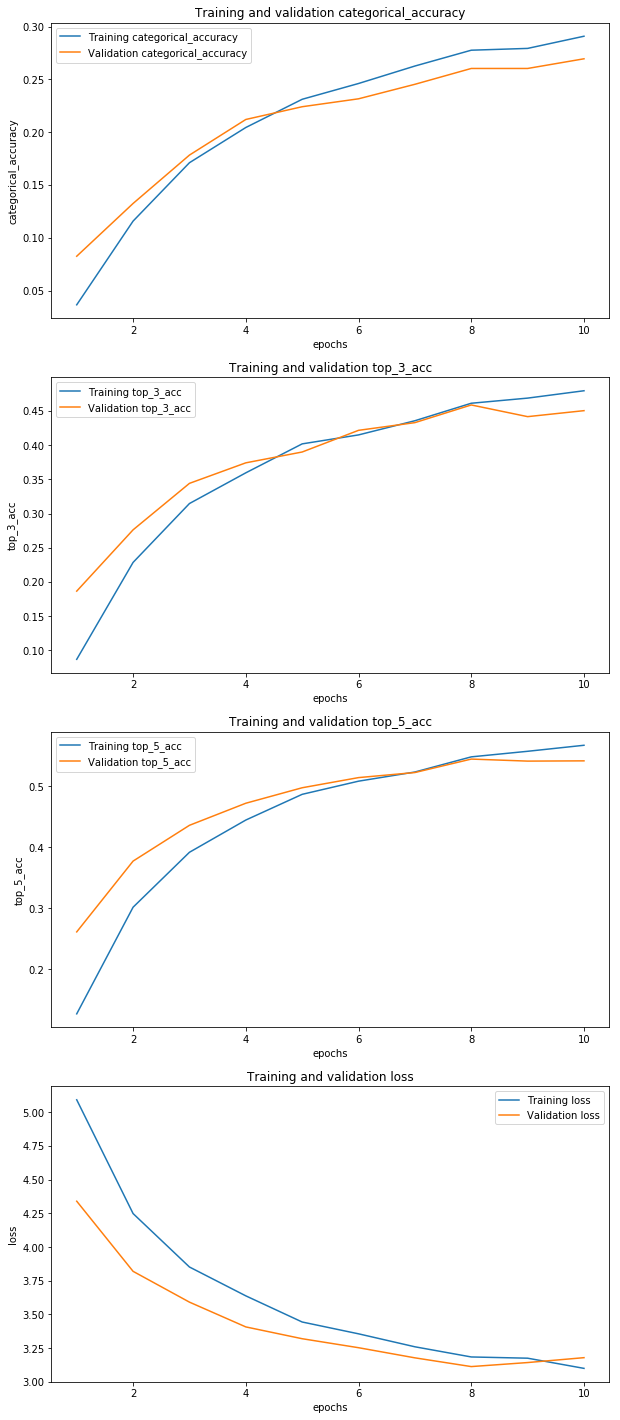

In [15]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'top_5_acc',
            'loss']
show = plot_metrics(summary.history, key_list)

## Unfreeze last layer for fine-tuning

In [16]:
### load weights from training above if instance or kernel was interrupted
# WEIGHT_PATH = os.path.join(SAVE_DIR, 'InceptionV3_13_10_20.h5')
# model.load_weights(WEIGHT_PATH)

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name in [
        'conv2d_86', 'batch_normalization_86',
        'conv2d_88', 'batch_normalization_88',
        'conv2d_89', 'batch_normalization_89',
        'conv2d_92', 'batch_normalization_92',
        'conv2d_93', 'batch_normalization_93',
        'conv2d_94', 'batch_normalization_94'
    ]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print('This is the number of trainable weights after '
      'after limited freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after after limited freezing the conv base: 14


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 196)               401604    
Total params: 22,204,388
Trainable params: 3,221,700
Non-trainable params: 18,982,688
_________________________________________________________________


## Recompile
(Especially if changing learning rate)

In [18]:
optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_3_acc, top_5_acc])

## Train to fine-tune!

In [24]:
EPOCHS = 10
start_time = time.time()
summary = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE)
end_time = time.time()

Epoch 1/10
354/354 [==============================] - 293s 828ms/step - loss: 1.3895 - categorical_accuracy: 0.6285 - top_3_acc: 0.8180 - top_5_acc: 0.8795 - val_loss: 2.0019 - val_categorical_accuracy: 0.4796 - val_top_3_acc: 0.6996 - val_top_5_acc: 0.7850
Epoch 2/10
354/354 [==============================] - 295s 832ms/step - loss: 1.3618 - categorical_accuracy: 0.6302 - top_3_acc: 0.8253 - top_5_acc: 0.8858 - val_loss: 1.8978 - val_categorical_accuracy: 0.5133 - val_top_3_acc: 0.7238 - val_top_5_acc: 0.7942
Epoch 3/10
354/354 [==============================] - 291s 822ms/step - loss: 1.3275 - categorical_accuracy: 0.6458 - top_3_acc: 0.8335 - top_5_acc: 0.8905 - val_loss: 1.8939 - val_categorical_accuracy: 0.5133 - val_top_3_acc: 0.7262 - val_top_5_acc: 0.8037
Epoch 4/10
354/354 [==============================] - 294s 832ms/step - loss: 1.2820 - categorical_accuracy: 0.6581 - top_3_acc: 0.8403 - top_5_acc: 0.8945 - val_loss: 1.8182 - val_categorical_accuracy: 0.5083 - val_top_3_acc:

In [26]:
time_save_model(model,
                summary.history,
                start_time, end_time,
                'InceptionV3_16_FT_10_20',
                SAVE_DIR)

traing took: 49.0 minutes


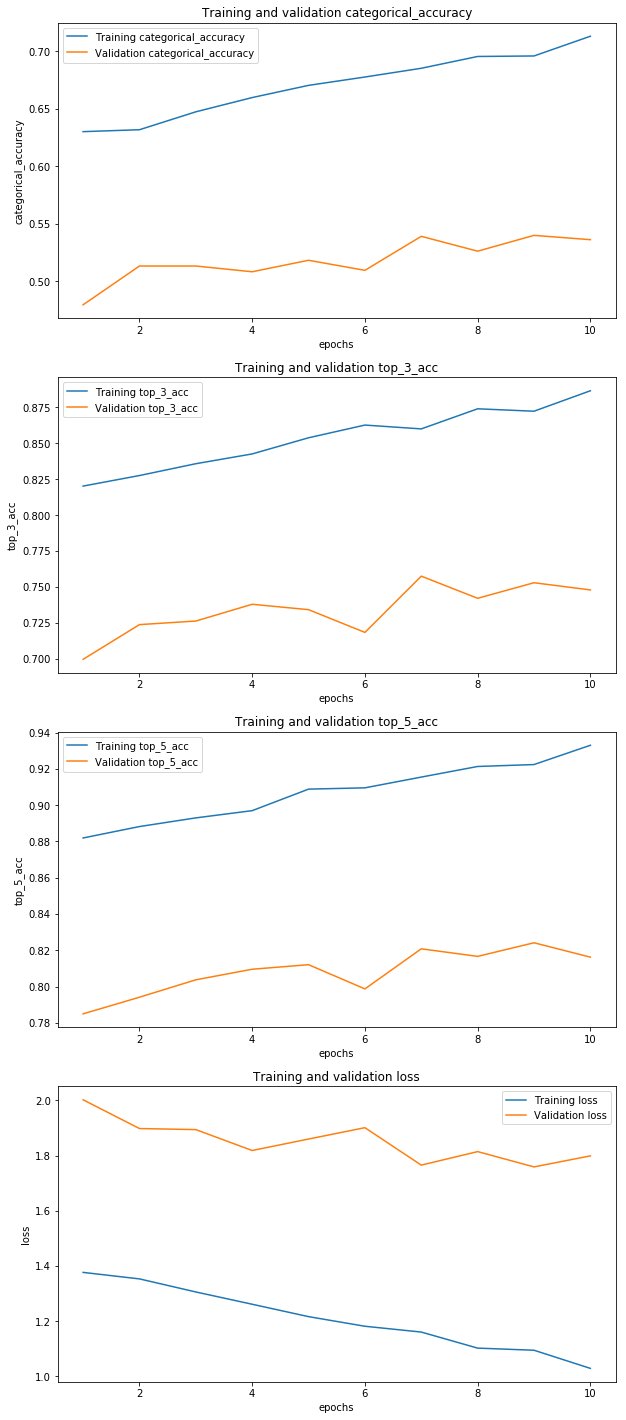

In [27]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'top_5_acc',
            'loss']
show = plot_metrics(summary.history, key_list)